In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import corner

import matplotlib as mpl
import matplotlib.pyplot as plt

import kdes

## Cholesky Whitening and Coloring

data:
[[6.29229349 3.40933993]
 [3.40933993 2.23835478]]
[[0.92679743 0.03169471]
 [0.03169471 0.99482435]]
clean:
[[ 0.97484224 -0.01036362]
 [-0.01036362  0.88348464]]
[[6.09276401 3.27315233]
 [3.27315233 2.13604421]]


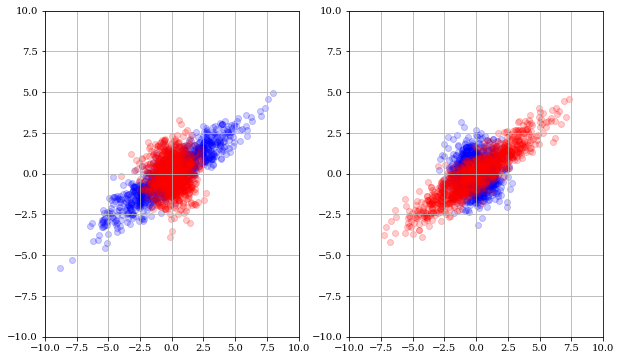

In [35]:
NUM = 1000

sigma = [2.5, 1.5]
corr = 0.9

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
cov_inv = np.linalg.inv(cov)
color = sp.linalg.cholesky(cov)
white = sp.linalg.cholesky(cov_inv)

data = np.random.multivariate_normal([0.0, 0.0], cov, NUM).T
clean = np.random.multivariate_normal([0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]], size=NUM).T

norm = np.sqrt(np.linalg.det(2*np.pi*cov))

data_inv = np.dot(white, data)
clean_col = np.dot(color.T, clean)


print("data:")
print(np.cov(*data))
print(np.cov(*data_inv))

print("clean:")
print(np.cov(*clean))
print(np.cov(*clean_col))



fig, axes = plt.subplots(figsize=[10, 6], ncols=2)
for ax in axes:
    ax.set(xlim=[-10, 10], ylim=[-10, 10])
    ax.grid()

ax = axes[0]
ax.scatter(*data, alpha=0.2, color='b')
ax.scatter(*data_inv, alpha=0.2, color='r')

ax = axes[1]
ax.scatter(*clean, alpha=0.2, color='b')
ax.scatter(*clean_col, alpha=0.2, color='r')

plt.show()

clean:
[[12.46157456  0.19100652]
 [ 0.19100652 12.03578347]]
[[12.46157456  5.15969019]
 [ 5.15969019 12.24395833]]


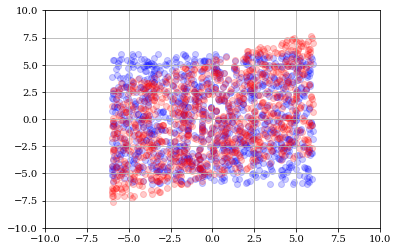

In [48]:
NUM = 1000

sigma = [1.0, 1.0]
corr = 0.4

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]

cov = np.array(cov)
cov_inv = np.linalg.inv(cov)
color = sp.linalg.cholesky(cov)
white = sp.linalg.cholesky(cov_inv)

# data = np.random.multivariate_normal([0.0, 0.0], cov, NUM).T
# clean = np.random.multivariate_normal([0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]], size=NUM).T
clean = np.random.uniform(-1.0, 1.0, size=2*NUM).reshape(2, NUM) * 6

# data_inv = np.dot(white, data)
clean_col = np.dot(color.T, clean)

print("clean:")
print(np.cov(*clean))
print(np.cov(*clean_col))


fig, ax = plt.subplots()   # figsize=[10, 6], ncols=2)
ax.set(xlim=[-10, 10], ylim=[-10, 10])
ax.grid()

ax.scatter(*clean, alpha=0.2, color='b')
ax.scatter(*clean_col, alpha=0.2, color='r')

plt.show()